[*********************100%%**********************]  1 of 1 completed


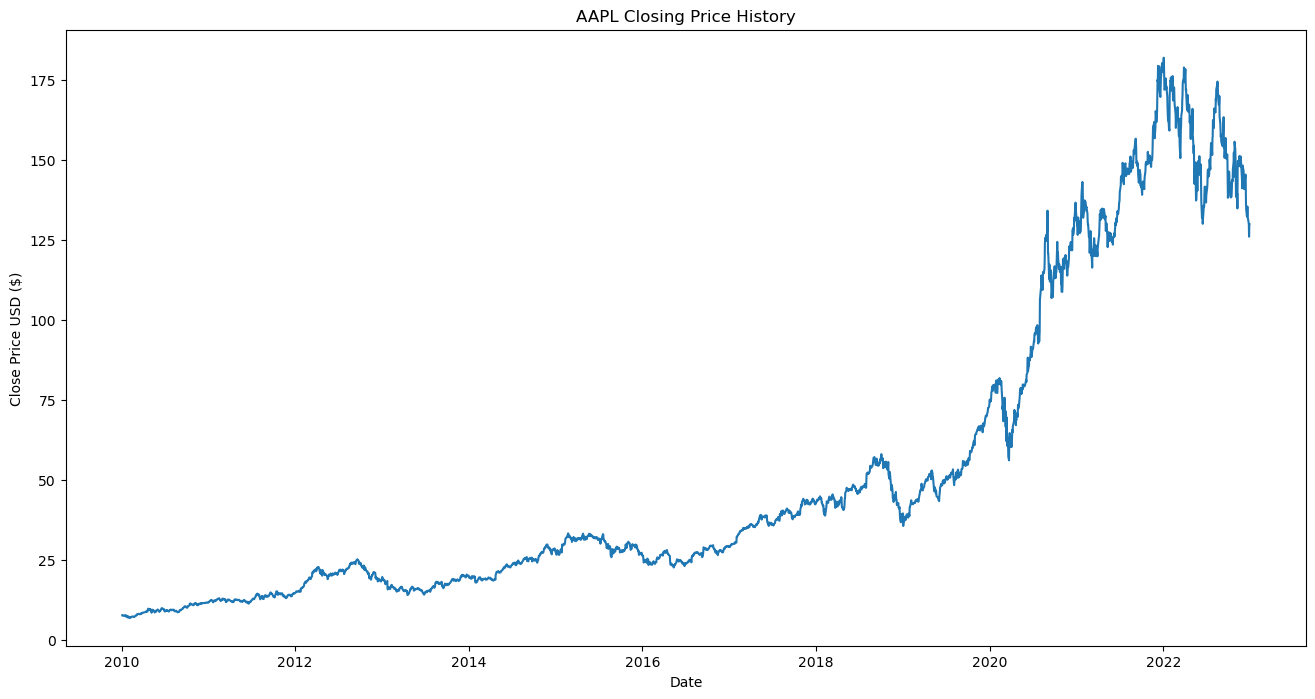

C:\Users\KPRIET\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2516/2516 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - loss: 3.8331e-04
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Train RMSE: 1.25
Test RMSE: 8.06


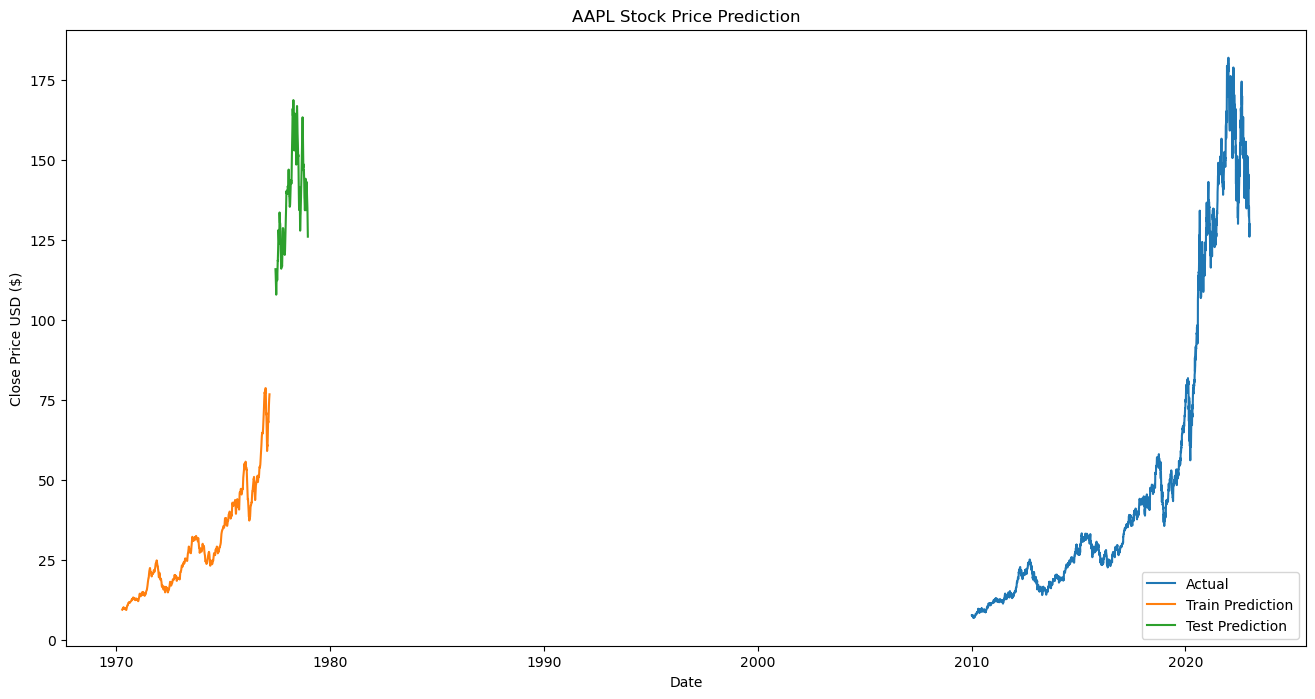

In [30]:
# Stock Price Prediction with LSTM_Palanichamy Naveen

#1. Setting up the Environment

#pip install pandas numpy matplotlib scikit-learn tensorflow

# 2. Loading the Dataset

#pip install yfinance

# 3. Preprocessing the Data

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Load the dataset
ticker = 'AAPL'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01')
data = data[['Close']]

# Plot the closing price history
plt.figure(figsize=(16, 8))
plt.title(f'{ticker} Closing Price History')
plt.plot(data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.show()

# Preprocess the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape the input data for LSTM [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 4. Building the LSTM Model
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# 5. Making Predictions

# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(np.mean(((train_predict - y_train.T) ** 2)))
test_rmse = np.sqrt(np.mean(((test_predict - y_test.T) ** 2)))

print(f'Train RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')

# 6. Visualizing the Results

# Plotting
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(scaled_data) - 1, :] = test_predict

plt.figure(figsize=(16, 8))
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(data['Close'])
plt.plot(pd.DataFrame(train_predict_plot, columns=['Close']))
plt.plot(pd.DataFrame(test_predict_plot, columns=['Close']))
plt.legend(['Actual', 'Train Prediction', 'Test Prediction'], loc='lower right')
plt.show()